In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import itertools
from collections import defaultdict
from IPython.display import clear_output

# Classes

In [2]:
class Grid:
    def __init__(self, minute_part, hours = 24):
        self.hours = hours
        self.minute_part = minute_part
        self.Grid = pd.DataFrame(None, columns= [(y, x) for y in range(hours) for x in range(minute_part)], dtype = bool)
        
    def insert(self, idx, times: list):
            
        self.Grid.loc[idx] = [ x in set(times) for x in self.Grid.columns]
        
    def delete(self, idx):
        if idx in self.Grid.index:
            self.Grid.drop(index=idx, inplace= True)
        else:
            print("Not in index")
    
    def change(self, idx, times: list, value):
        self.Grid.loc[idx] = [ value if x in set(times) else y for x,y in zip(self.Grid.columns, self.Grid.loc[idx])]
    
    def isAvailable(self, idx, times: list):
        if idx not in self.Grid.index:
            print("Not an appropriate index")
            return False
        
        pos = self.Grid.index.get_loc(idx)
        return self.Grid.iloc[pos, times[0]*self.minute_part + times[1]]
    
    def getTotal(self, times):
        return self.Grid[times].sum()
    def getTotalbyidx(self, idx):
        return self.Grid.loc[idx].sum()
    
    def getAvailable(self, time):
        return self.Grid.loc[self.Grid[time] == True][time]
    
    def getEntropy(self):
        if self.Grid.shape[0] == 0 or self.Grid.shape[1] == 0:
            return np.zeros(shape=self.Grid.shape)
        
        EntropybyRow = np.zeros(shape=(self.Grid.shape[0],1))
        EntropybyCol = np.zeros(shape=(1,self.Grid.shape[1]))

        for count, person in enumerate(self.Grid.index):
            prob = self.getTotalbyidx(person)/self.Grid.shape[1]

            EntropybyRow[count] = entropy([prob, 1-prob])

        for count, time in enumerate(self.Grid):
            prob = self.getTotal(time)/self.Grid.shape[0]
        
            EntropybyCol[0,count] = entropy([prob, 1-prob])
    
        EntTable = EntropybyCol+EntropybyRow
        EntTable[~self.Grid.to_numpy()] = np.inf
        print("E Done")
        return EntTable
    
    def getMutualInformation(self):
        
        if self.Grid.shape[0] == 0 or self.Grid.shape[1] == 0:
            return np.zeros(shape=self.Grid.shape)
        
        ProbByRow = np.zeros(shape=(self.Grid.shape[0],1))
        ProbByCol = np.zeros(shape=(1,self.Grid.shape[1]))
        
        for count, person in enumerate(self.Grid.index):
            prob = self.getTotalbyidx(person)/self.Grid.shape[1]

            ProbByRow[count] = prob

        for count, time in enumerate(self.Grid):
            prob = self.getTotal(time)/self.Grid.shape[0]
        
            ProbByCol[0,count] = prob
            
        probTable = ProbByRow * ProbByCol
        
        for row in range(probTable.shape[0]):
            for col in range(probTable.shape[1]):
                probTable[row, col] = entropy([probTable[row,col], 1-probTable[row,col]])
        
        #print(probTable)
        print("Done")
        return self.getEntropy() - probTable
        
    def getNextAvailable(self, time):
        ser = self.getAvailable(time)
        return ser.sort_index(key = lambda x: [self.getTotalbyidx(y) for y in x])
    def print(self):
        print(self.Grid)
    

In [3]:
class Person:
    newid = itertools.count()
    def __init__(self, id = None, availability= set()):
        if id is None:
            self.id = next(Person.newid)
        else:
            self.id = id
            
        self.availability = set()
        
    def reset():
        Person.newid = itertools.count()
        
            

In [4]:
def getBestSpot(people, grid):
    
    #EntTable = grid.getEntropy()
    EntTable = grid.getMutualInformation()
    #print(EntTable.shape)
    
    tableInd = EntTable.argsort(axis=1)
 
    best = {person.id: table[0] for person, table in zip(people ,tableInd)}
    idxCt = defaultdict(int)
    ct = 1
    #print(best)
    while len(set(best.values())) != len(best):
        last = {}
        for count, k in enumerate(best):
            best[k] = tableInd[count, idxCt[k]]
            
            if best[k] not in last:
                last[best[k]] = k
                #print(last)
            else:
                #compare with last instance of the entropy table index
                #print("Index: ", last[best[k]] , " Entropy: ", EntTable[ last[best[k]], best[ last[best[k]] ] ])
                #print("Second Index: ", k, " Entropy: ", EntTable[count, best[k]])
                test_last = tableInd[last[best[k]], idxCt[last[best[k]]]+1 ]
                test_new = tableInd[count, idxCt[k]+1]
                if EntTable[ last[best[k]] , best[ last[best[k]] ] ] > EntTable[count, best[k]]:
                    #print("Index: ", last[best[k]] , " Entropy: ", EntTable[ last[best[k]], best[ last[best[k]] ] ])
                    #print("Second Index: ", k, " Entropy: ", EntTable[count, best[k]])
                    
                    
                    if not np.isinf(EntTable[ last[best[k]], test_last]):
                        idxCt[ last[best[k]] ] += 1
                    else:
                        #print("Testing Other... ")
                        if not np.isinf(EntTable[count, test_new]):
                            idxCt[k] += 1
                        else:
                            print("Unresolvable")
                            return None, tableInd, idxCt, EntTable
                else:
                    if not np.isinf(EntTable[count, test_new]):
                        idxCt[k] += 1
                    else:
                        #print("Testing Other... ")
                        if not np.isinf(EntTable[ last[best[k]], test_last]):
                            idxCt[ last[best[k]] ] += 1
                        else:
                            print("Unresolvable")
                            return None, tableInd, idxCt, EntTable
                    
                #update to current instance
                last[best[k]] = k
            ct += 1
            print("Alg1:, ", len(set(best.values())), "/", len(best))
            if ct % 2 == 0:
                clear_output(wait=True)
        
    return best, tableInd, idxCt, EntTable



In [5]:
def getBestSpot2(people, grid):
    #EntTable = grid.getEntropy()
    EntTable = grid.getMutualInformation()
    
    #return a list of indices representing Entropy in ascending order
    tableInd = EntTable.argsort(axis=1)
 
    best = {person.id: table[0] for person, table in zip(people ,tableInd)}
    idxCt = defaultdict(int)
    
    #for each key set a counter to the beginning of the list
    ct = 1
    #condition to ensure each one is unique
    while len(set(best.values())) != len(best):
        conflict = {}
        #find conflicts
        for k in best:
            if best[k] not in conflict:
                conflict[best[k]] = []
            
            conflict[best[k]].append(k)
        #resolve conflicts
        
        for k in conflict:
            lastIdx = 0
            if len(set(conflict[k])) != len(conflict[k]):
                print("Hi")
            #for each step compare to previous minimum value in Information Table (EntTable) and
            # if no longer the min value or if greater - incriment counter on respective keys
            for count, val in enumerate(conflict[k]):
                if val == conflict[k][lastIdx]:
                    #print("Next")
                    continue

                test_last = tableInd[conflict[k][lastIdx], idxCt[conflict[k][lastIdx]]+1 ]
                test_new = tableInd[val, idxCt[val]+1]
                
                if EntTable[val, k] < EntTable[conflict[k][lastIdx], k]:
                    #print("less")
                    if not np.isinf(EntTable[conflict[k][lastIdx], test_last]):
                        idxCt[conflict[k][lastIdx]] += 1
                        lastIdx = count
                    else:
                        if not np.isinf(EntTable[val, test_new]):
                            idxCt[conflict[k][count]] += 1
                        else:
                            print("Unresolvable")
                            return None, tableInd, idxCt, EntTable
                
                elif EntTable[val, k] > EntTable[conflict[k][lastIdx], k]:
                    #print("more")
                    if not np.isinf(EntTable[val, test_new]):
                        idxCt[conflict[k][count]] += 1
                    else:
                        if not np.isinf(EntTable[conflict[k][lastIdx], test_last]):
                            idxCt[conflict[k][lastIdx]] += 1
                            lastIdx = count
                        else:
                            print("Unresolvable")
                            return None, tableInd, idxCt, EntTable
                #when equal resolve by next least value
                else:
                    #break ties on lookahead
                    
                    if EntTable[val, test_new] < EntTable[conflict[k][lastIdx], test_last]:
                        if not np.isinf(EntTable[conflict[k][lastIdx], test_last]):
                            idxCt[conflict[k][lastIdx]] += 1
                            lastIdx = count
                        else:
                            if not np.isinf(EntTable[val, test_new]):
                                idxCt[conflict[k][count]] += 1
                            else:
                                print("Unresolvable")
                                return None, tableInd, idxCt, EntTable
                    else:
                        if not np.isinf(EntTable[val, test_new]):
                            idxCt[conflict[k][count]] += 1
                        else:
                            if not np.isinf(EntTable[conflict[k][lastIdx], test_last]):
                                idxCt[conflict[k][lastIdx]] += 1
                                lastIdx = count
                            else:
                                print("Unresolvable")
                                return None, tableInd, idxCt, EntTable

            print("Alg2:, ", len(set(best.values())), "/", len(best))
            ct+= 1
            #update table
            for k in best:
                best[k] = tableInd[k, idxCt[k]]
            if ct % 2 == 0:
                clear_output(wait=True)
        
    return best, tableInd, idxCt, EntTable

In [6]:
HOUR_PARTITIONS = 48
HOURS = 24
Num_People = 26
def fillGrid(perc):
    return math.floor(perc* (HOUR_PARTITIONS*HOURS))
people = [Person() for x in range(Num_People)]

In [7]:
schedule = Grid(HOUR_PARTITIONS)

def createTupList(Hours, Minutes, size):
    #s = set()
    #while len(s) != size:
    #    s.add(tuple(np.random.randint(maxval, size = 2, dtype = np.uint64)))
    #print("\n", list(s))
    #print("Length of list: ", len(s))
    #return list(s)
    return [(np.random.randint(Hours, dtype=np.uint64), np.random.randint(Minutes, dtype=np.uint64)) for x in range(size)]

for person in people:
    r_size = np.random.randint(schedule.Grid.shape[1], dtype = np.uint64)
    #print(person.id)
    schedule.insert(person.id, createTupList(HOURS, HOUR_PARTITIONS, r_size))
    
schedule.print()

    (0, 0)  (0, 1)  (0, 2)  (0, 3)  (0, 4)  (0, 5)  (0, 6)  (0, 7)  (0, 8)  \
0    False   False    True    True    True   False    True   False   False   
1    False   False   False   False    True   False   False   False   False   
2    False   False    True   False   False    True   False   False   False   
3    False    True    True   False   False    True    True   False   False   
4    False   False    True   False    True   False   False   False   False   
5     True    True    True    True   False   False   False    True   False   
6    False   False   False   False   False   False   False   False   False   
7    False   False   False   False    True   False   False   False   False   
8    False    True    True   False   False   False   False    True    True   
9     True   False   False   False   False    True    True   False    True   
10    True   False   False   False    True   False   False    True    True   
11    True   False   False    True   False    True   False   Fal

In [8]:
test = Grid(4, hours = 4)
#test.print()
test.insert(20, [(0,0),(0,3),(2,2)])

test.insert(0, [(0,3)])
test.insert(3, [(0,0)])
test.change(3, [(1,0)], True)

print("Test is Available: ", test.isAvailable(3, (1,1)), "\n" )
display(test.getAvailable((0,0)) )
print("\nTest Total by Row: ", test.getTotalbyidx(20))
print("Test Total by Column: ", test.getTotal((0,0)), "\n" )

display(test.getNextAvailable((0,0)) )
display(test.Grid)
print(test.Grid.shape)

Test is Available:  False 



20    True
3     True
Name: (0, 0), dtype: bool


Test Total by Row:  3
Test Total by Column:  2 



3     True
20    True
Name: (0, 0), dtype: bool

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(2, 0)","(2, 1)","(2, 2)","(2, 3)","(3, 0)","(3, 1)","(3, 2)","(3, 3)"
20,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False
0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


(3, 16)


In [9]:
test.delete(4)
test.getTotal((2,2))

Not in index


1

In [10]:
test.print()

    (0, 0)  (0, 1)  (0, 2)  (0, 3)  (1, 0)  (1, 1)  (1, 2)  (1, 3)  (2, 0)  \
20    True   False   False    True   False   False   False   False   False   
0    False   False   False    True   False   False   False   False   False   
3     True   False   False   False    True   False   False   False   False   

    (2, 1)  (2, 2)  (2, 3)  (3, 0)  (3, 1)  (3, 2)  (3, 3)  
20   False    True   False   False   False   False   False  
0    False   False   False   False   False   False   False  
3    False   False   False   False   False   False   False  


In [11]:
test.isAvailable(4, (2,2))

Not an appropriate index


False

In [12]:
test.isAvailable(3, (1,0))

True

# Calculate the loss 
- Entropy of the person plus entropy of the space, H(P(x)/m*n) + H(M(x)/X)
    - minimize such that the total entropy of remaining spaces is the most possible
- where E(P(x)/m*n) is the entropy for person,P, and P(x) is total available
- where E(M(x)/X) is the entropy of available People, M(x), against total People, X
# Operations:
How to keep track of positions
How to deal with failure end state (is it reversible?)
How to represent success state (used dictionary)
Best way to find next position (sorted numpy array along index)

# Failure States:
When X > m*n
When dictionary reaches inf.
# Success state:
When all values in Dictonary are unique

In [13]:
out = ""
for count, person in enumerate(people, 1):
    out += str(person.id) + " Person available in " + str(schedule.getTotalbyidx(person.id)) + " Spots\t\t"
    if count % 2 == 0:
        print(out)
        out = ""

if out != "":
    print(out)

0 Person available in 722 Spots		1 Person available in 79 Spots		
2 Person available in 426 Spots		3 Person available in 287 Spots		
4 Person available in 525 Spots		5 Person available in 658 Spots		
6 Person available in 18 Spots		7 Person available in 213 Spots		
8 Person available in 564 Spots		9 Person available in 520 Spots		
10 Person available in 371 Spots		11 Person available in 513 Spots		
12 Person available in 600 Spots		13 Person available in 546 Spots		
14 Person available in 655 Spots		15 Person available in 318 Spots		
16 Person available in 368 Spots		17 Person available in 536 Spots		
18 Person available in 270 Spots		19 Person available in 383 Spots		
20 Person available in 230 Spots		21 Person available in 551 Spots		
22 Person available in 656 Spots		23 Person available in 54 Spots		
24 Person available in 49 Spots		25 Person available in 321 Spots		


In [14]:
out = ""
for count, person in enumerate(people, 1):
    out += str(person.id) + " Person available {:.4%} of times\t".format(schedule.getTotalbyidx(person.id)/schedule.Grid.shape[1])
    if count % 2 == 0:
        print(out)
        out = ""
if out != "":
    print(out)

0 Person available 62.6736% of times	1 Person available 6.8576% of times	
2 Person available 36.9792% of times	3 Person available 24.9132% of times	
4 Person available 45.5729% of times	5 Person available 57.1181% of times	
6 Person available 1.5625% of times	7 Person available 18.4896% of times	
8 Person available 48.9583% of times	9 Person available 45.1389% of times	
10 Person available 32.2049% of times	11 Person available 44.5312% of times	
12 Person available 52.0833% of times	13 Person available 47.3958% of times	
14 Person available 56.8576% of times	15 Person available 27.6042% of times	
16 Person available 31.9444% of times	17 Person available 46.5278% of times	
18 Person available 23.4375% of times	19 Person available 33.2465% of times	
20 Person available 19.9653% of times	21 Person available 47.8299% of times	
22 Person available 56.9444% of times	23 Person available 4.6875% of times	
24 Person available 4.2535% of times	25 Person available 27.8646% of times	


In [15]:
disp = pd.DataFrame(schedule.getEntropy(), columns= schedule.Grid.columns)

E Done


In [16]:
display(disp)

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)",...,"(23, 38)","(23, 39)","(23, 40)","(23, 41)","(23, 42)","(23, 43)","(23, 44)","(23, 45)","(23, 46)","(23, 47)"
0,inf,inf,1.341936,1.277912,1.326948,inf,1.243162,inf,inf,inf,...,1.200874,inf,inf,inf,1.326948,1.341936,1.326948,inf,1.326948,inf
1,inf,inf,inf,inf,0.916219,inf,inf,inf,inf,inf,...,0.790145,inf,inf,inf,inf,inf,inf,inf,inf,inf
2,inf,inf,1.340110,inf,inf,1.241337,inf,inf,inf,1.241337,...,inf,inf,inf,1.349030,1.325123,1.340110,1.325123,1.276086,inf,inf
3,inf,1.101584,1.242645,inf,inf,1.143872,1.143872,inf,inf,inf,...,1.101584,inf,1.178621,inf,1.227658,inf,1.227658,inf,inf,inf
4,inf,inf,1.370488,inf,1.355501,inf,inf,inf,inf,inf,...,inf,1.178774,inf,1.379408,inf,1.370488,inf,1.306464,1.355501,1.379408
5,1.328012,1.223183,1.364245,1.300221,inf,inf,inf,1.364245,inf,inf,...,inf,inf,inf,1.373165,inf,1.364245,1.349258,inf,inf,1.373165
6,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
7,inf,inf,inf,inf,1.145015,inf,inf,inf,inf,inf,...,1.018941,inf,inf,inf,inf,inf,inf,inf,inf,1.168922
8,inf,1.233134,1.374196,inf,inf,inf,inf,1.374196,1.383116,inf,...,inf,inf,1.310172,1.383116,inf,inf,inf,inf,1.359209,inf
9,1.333447,inf,inf,inf,inf,1.270906,1.270906,inf,1.378599,inf,...,inf,inf,1.305655,1.378599,inf,inf,inf,inf,inf,1.378599


In [17]:
pd.DataFrame(schedule.getMutualInformation(), columns= schedule.Grid.columns)

Done
E Done


,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)",...,"(23, 38)","(23, 39)","(23, 40)","(23, 41)","(23, 42)","(23, 43)","(23, 44)","(23, 45)","(23, 46)","(23, 47)"
0,inf,inf,0.763553,0.787594,0.774658,inf,0.789285,inf,inf,inf,...,0.787592,inf,inf,inf,0.774658,0.763553,0.774658,inf,0.774658,inf
1,inf,inf,inf,inf,0.794311,inf,inf,inf,inf,inf,...,0.708831,inf,inf,inf,inf,inf,inf,inf,inf,inf
2,inf,inf,0.906374,inf,inf,0.917223,inf,inf,inf,0.917223,...,inf,inf,inf,0.892079,0.916137,0.906374,0.916137,0.921736,inf,inf
3,inf,0.881573,0.905852,inf,inf,0.897868,0.897868,inf,inf,inf,...,0.881573,inf,0.908096,inf,0.911858,inf,0.911858,inf,inf,inf
4,inf,inf,0.880218,inf,0.891340,inf,inf,inf,inf,inf,...,inf,0.881730,inf,0.865006,inf,0.880218,inf,0.901093,0.891340,0.865006
5,0.830792,0.833369,0.811267,0.835337,inf,inf,inf,0.811267,inf,inf,...,inf,inf,inf,0.796354,inf,0.811267,0.822749,inf,inf,0.796354
6,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
7,inf,inf,inf,inf,0.888505,inf,inf,inf,inf,inf,...,0.842608,inf,inf,inf,inf,inf,inf,inf,inf,0.877309
8,inf,0.880432,0.864065,inf,inf,inf,inf,0.864065,0.848765,inf,...,inf,inf,0.886353,0.848765,inf,inf,inf,inf,0.875458,inf
9,0.900048,inf,inf,inf,inf,0.900948,0.900948,inf,0.866859,inf,...,inf,inf,0.902714,0.866859,inf,inf,inf,inf,inf,0.866859


In [18]:
points = [] # [ [[],[]], ...]
for idx, row in disp.iterrows():
    data = []
    col = []
    for count, (pt, column) in enumerate(zip(row,disp.columns)):
        if schedule.isAvailable(idx, column):
            col.append(count)
            data.append(pt)
    points.append([col, data])

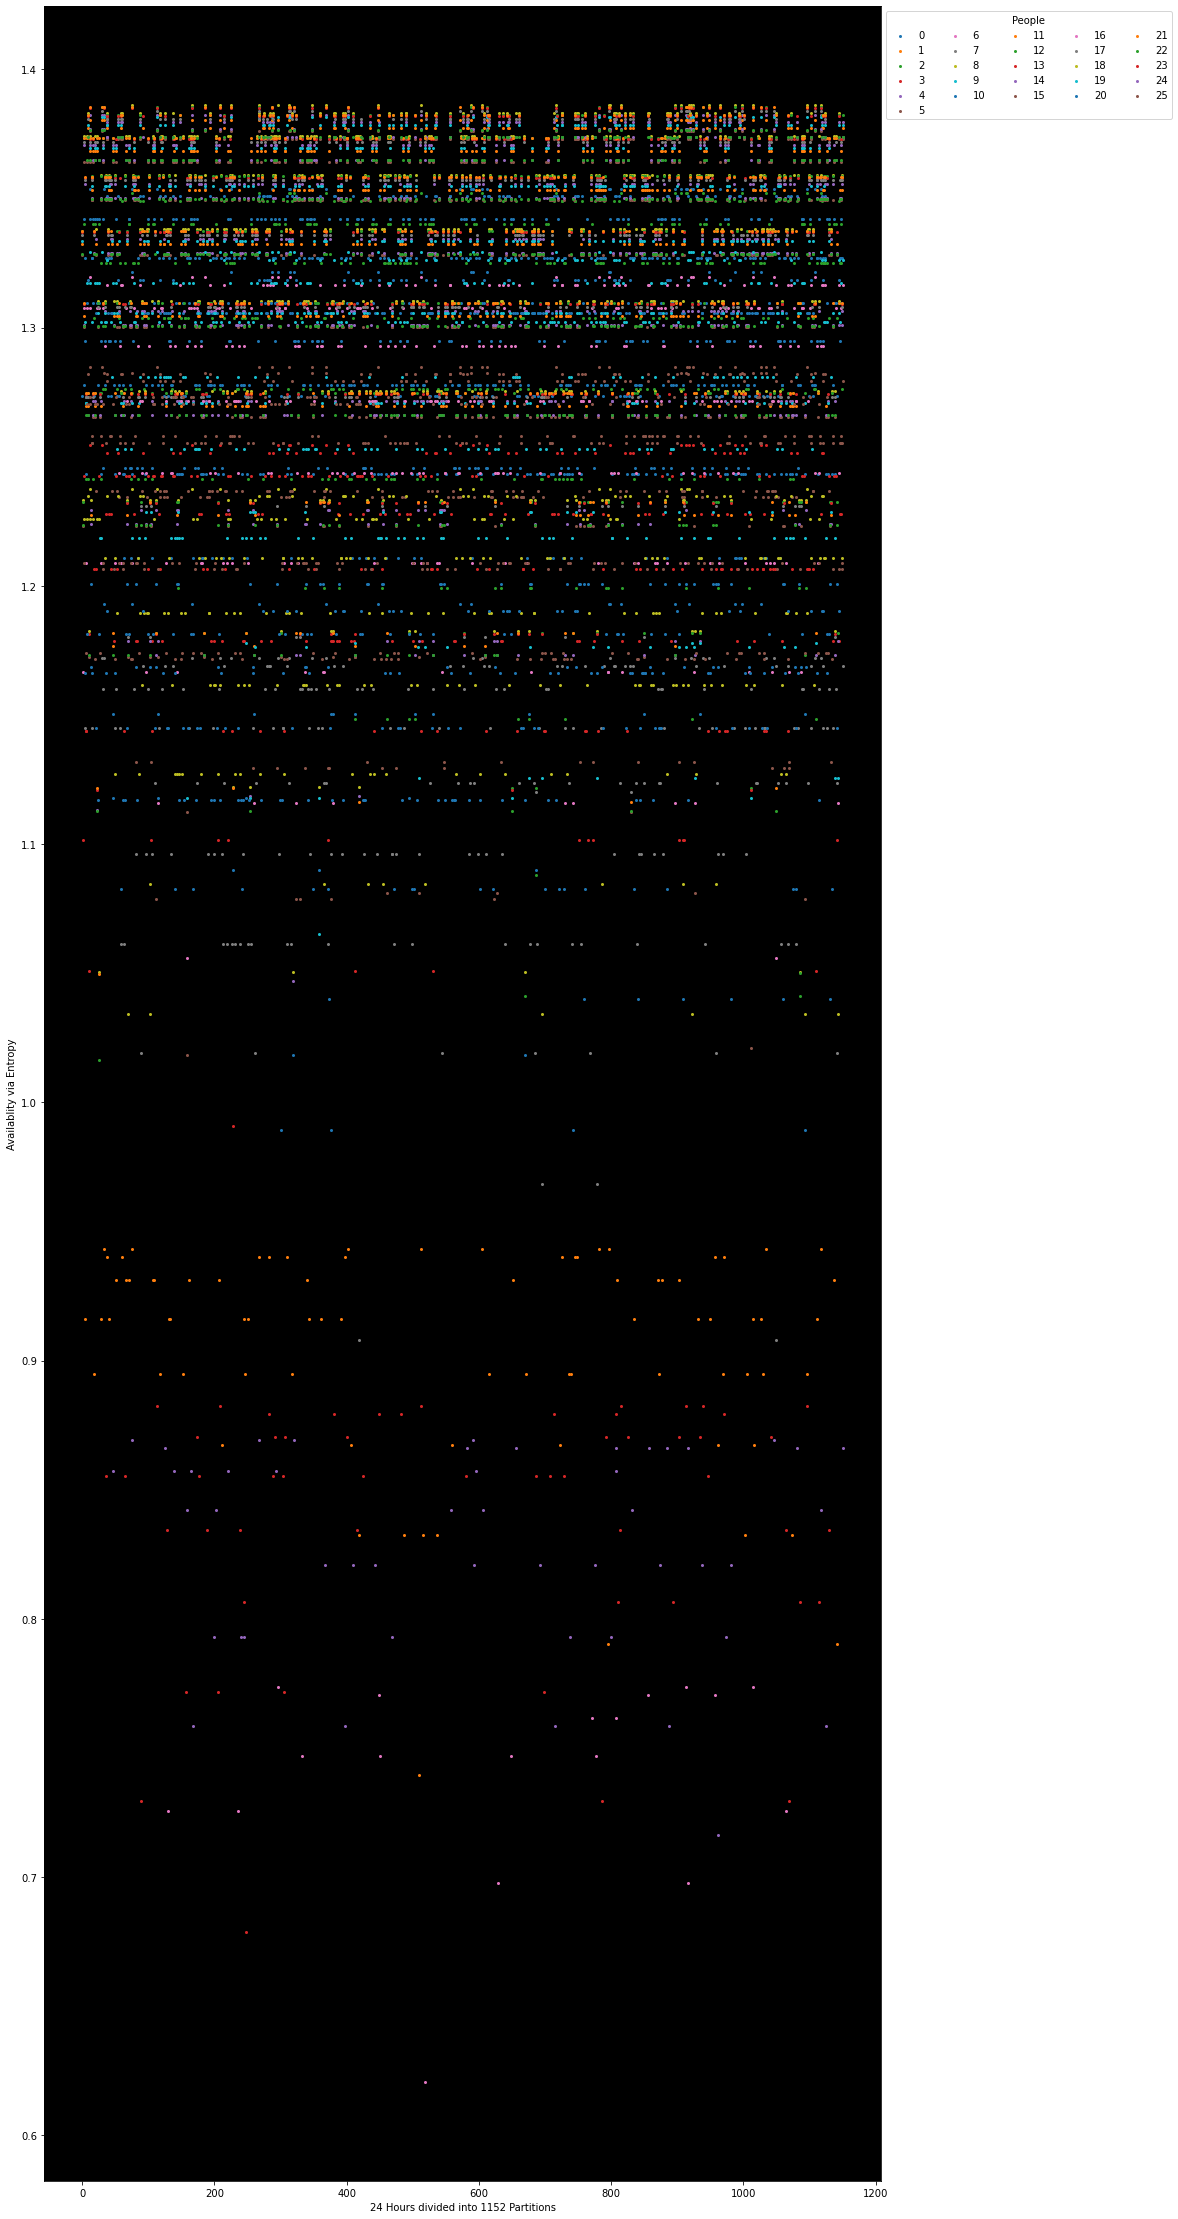

In [19]:
fig , ax = plt.subplots()

for pts, idx in zip(points, disp.index):
    ax.scatter(pts[0], pts[1], s = 4, label = idx)
    
ax.legend(title = "People", loc = "upper left", bbox_to_anchor = (1, 1), ncol = math.floor(math.sqrt(disp.shape[0])), fancybox = True)

ax.set_facecolor('black')
ax.set_xlabel("{Hours:} Hours divided into {Min_part} Partitions".format(Hours=HOURS, Min_part = HOURS*HOUR_PARTITIONS))
ax.set_ylabel("Availablity via Entropy")
fig.set_figwidth(15)
fig.set_figheight(40)

#plot = plt.scatter(np.arange(len(disp.columns))+ np.zeros(shape=(len(disp.index), 1), dtype = int), disp.to_numpy())
plt.show()

In [20]:
best, idxes, idxCts, Entropy = getBestSpot(people, schedule)

best2, idxes2, idxCts2, Entropy2 = getBestSpot2(people, schedule)

Alg2:,  26 / 26


In [21]:
output = ""
summ = 0
for count, spot in enumerate(best):
    output += str(spot) + ": " + str(best[spot]) + ", Entropy: {:4}".format(Entropy[count,best[spot]]) + "\t\t"
    summ +=  Entropy[count,best[spot]]
    if (count+1) % 2 == 0:
        print(output)
        output = ""
        
if output != "":
    print(output)
print("Total capacity:", summ)

0: 244, Entropy: 0.5935301306421632		1: 510, Entropy: 0.6693095163655681		
2: 293, Entropy: 0.8217602523558812		3: 228, Entropy: 0.8281089822452423		
4: 1089, Entropy: 0.7943982244863329		5: 938, Entropy: 0.6672387980994515		
6: 518, Entropy: 0.5968064730985965		7: 1049, Entropy: 0.7787632789382856		
8: 291, Entropy: 0.7789417000514794		9: 306, Entropy: 0.7961870700584971		
10: 520, Entropy: 0.857336238074258		11: 11, Entropy: 0.7986183612848472		
12: 416, Entropy: 0.7622734966873268		13: 1039, Entropy: 0.7864080004227897		
14: 107, Entropy: 0.7322067310366833		15: 158, Entropy: 0.8427892412893466		
16: 1123, Entropy: 0.8575788933992095		17: 1042, Entropy: 0.790309195027693		
18: 69, Entropy: 0.8503194030288894		19: 725, Entropy: 0.8561926076035814		
20: 377, Entropy: 0.8266639544679288		21: 340, Entropy: 0.7843914609836536		
22: 36, Entropy: 0.7020385260049754		23: 248, Entropy: 0.6273389216004417		
24: 961, Entropy: 0.6609688075349851		25: 1011, Entropy: 0.8440369239513902		
Total ca

In [22]:
output = ""
summ = 0
for count, spot in enumerate(best2):
    output += str(spot) + ": " + str(best2[spot]) + ", Entropy: {:4}".format(Entropy2[count,best[spot]]) + "\t\t"
    summ +=  Entropy2[count,best[spot]]
    if (count+1) % 2 == 0:
        print(output)
        output = ""
        
if output != "":
    print(output)
print("Total Capacity: ", summ)

0: 244, Entropy: 0.5935301306421632		1: 510, Entropy: 0.6693095163655681		
2: 293, Entropy: 0.8217602523558812		3: 228, Entropy: 0.8281089822452423		
4: 1089, Entropy: 0.7943982244863329		5: 938, Entropy: 0.6672387980994515		
6: 518, Entropy: 0.5968064730985965		7: 1049, Entropy: 0.7787632789382856		
8: 291, Entropy: 0.7789417000514794		9: 306, Entropy: 0.7961870700584971		
10: 520, Entropy: 0.857336238074258		11: 11, Entropy: 0.7986183612848472		
12: 416, Entropy: 0.7622734966873268		13: 1039, Entropy: 0.7864080004227897		
14: 107, Entropy: 0.7322067310366833		15: 158, Entropy: 0.8427892412893466		
16: 1123, Entropy: 0.8575788933992095		17: 1042, Entropy: 0.790309195027693		
18: 103, Entropy: 0.8503194030288894		19: 725, Entropy: 0.8561926076035814		
20: 377, Entropy: 0.8266639544679288		21: 340, Entropy: 0.7843914609836536		
22: 36, Entropy: 0.7020385260049754		23: 248, Entropy: 0.6273389216004417		
24: 961, Entropy: 0.6609688075349851		25: 1011, Entropy: 0.8440369239513902		
Total C

In [23]:
print("farthest incriment, ", max(idxCts.values()))
#print(idxes[:, :max(idxCts.values())])
series = idxes[:, :max(idxCts.values())]
dataSet = []
for count, row in enumerate(series):
    vals = []
    for val in row:
        vals.append(Entropy[count, val])
        
    dataSet.append(vals)

farthest incriment,  10


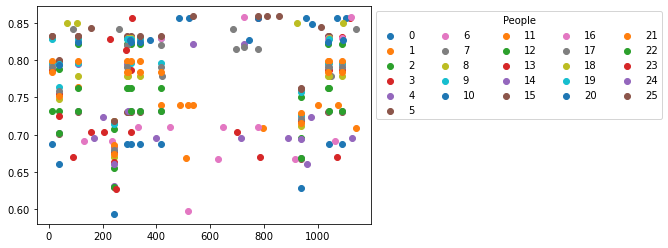

In [24]:
fig, ax = plt.subplots()

for count, (data, idx) in enumerate(zip(dataSet, series)):
    ax.scatter(idx, data, label = count)
EntVals = []
for k,v in best.items():
    EntVals.append(Entropy[k,v])
ax.legend(title = "People", loc = "upper left", bbox_to_anchor = (1, 1), ncol = math.floor(math.sqrt(disp.shape[0])), fancybox = True)
plt.show()

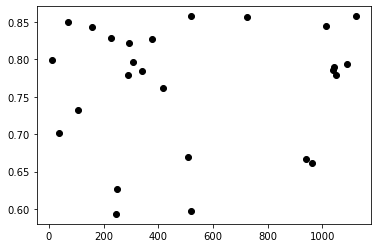

In [25]:
plt.scatter(best.values(), EntVals, c='black')
plt.show()

# Test

In [26]:
percents = [x/10 for x in range(0, 11, 2)]
TestSizes = []
ScheduleSet = [Grid(HOUR_PARTITIONS) for x in percents]
print(len(percents))
for perc in percents:
    Person.reset()
    TestSizes.append([Person() for x in range(fillGrid(perc))])

print("Set Loaded")
ct = 0
for timeSet, people in zip(ScheduleSet, TestSizes):
    
    for person in people:
        r_size = np.random.randint(timeSet.Grid.shape[1], dtype = np.uint64)
        #print(person.id)
        timeSet.insert(person.id, createTupList(HOURS, HOUR_PARTITIONS, r_size))
    
    ct += 1    
    print("Filled Set: ", ct)

6
Set Loaded
Filled Set:  1
Filled Set:  2
Filled Set:  3
Filled Set:  4
Filled Set:  5
Filled Set:  6


In [27]:
for timeSet in ScheduleSet:
    print(timeSet.Grid.shape)

(0, 1152)
(230, 1152)
(460, 1152)
(691, 1152)
(921, 1152)
(1152, 1152)


In [28]:
for timeSet, People in zip(ScheduleSet, TestSizes):
    b1, i, d, c = getBestSpot(People, timeSet)
    print(b1)
    b2, i ,d, c = getBestSpot2(People, timeSet)
    print(b2)


Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152


In [29]:
import timeit
g = []
g2 = []
ct = 1
for timeSet, People in zip(ScheduleSet, TestSizes):
    t = timeit.Timer(lambda: getBestSpot(People, timeSet))
    t2 = timeit.Timer(lambda: getBestSpot2(People, timeSet))
    
    g.append(t.repeat(number = 10))
    
    print("Next")
    
    g2.append(t2.repeat(number = 10))
    
    print("Done at, ", ct)
    ct += 1

Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152


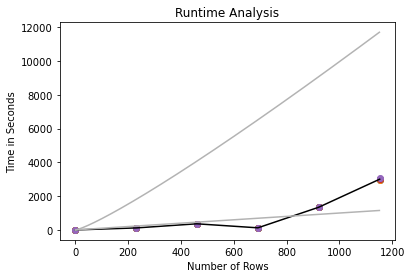

In [38]:
fig, ax = plt.subplots()
x = np.asarray([fillGrid(x) for x in percents])
y = np.asarray(g)

ax.plot(x[:, np.newaxis],y, 'o')
ax.plot(x, y.mean(axis=1), 'k')

ax.plot(np.arange(HOURS*HOUR_PARTITIONS), np.arange(HOURS*HOUR_PARTITIONS), '0.7')
ax.plot(np.arange(1, HOURS*HOUR_PARTITIONS), [x*math.log(x,2) for x in range(1, HOURS*HOUR_PARTITIONS)], '0.7')

ax.set_ylabel("Time in Seconds")
ax.set_xlabel("Number of Rows")
ax.set_title("Runtime Analysis")
plt.show()

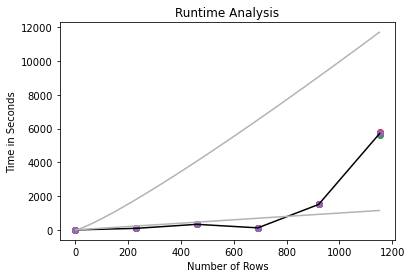

In [41]:
fig, ax = plt.subplots()
x = np.asarray([fillGrid(x) for x in percents])
y = np.asarray(g2)

ax.plot(x[:, np.newaxis],y, 'o')
ax.plot(x, y.mean(axis=1), 'k')

ax.plot(np.arange(HOURS*HOUR_PARTITIONS), np.arange(HOURS*HOUR_PARTITIONS), '0.7')
ax.plot(np.arange(1, HOURS*HOUR_PARTITIONS), [x*math.log(x,2) for x in range(1, HOURS*HOUR_PARTITIONS)], '0.7')

ax.set_ylabel("Time in Seconds")
ax.set_xlabel("Number of Rows")
ax.set_title("Runtime Analysis")
plt.show()